## OSVISIT DATA SET, 81.M
## BY: MEHDI RABBAI

In [56]:
#Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

In [17]:
#Load DATA
Signal = pd.read_csv("C:\\Users\\RABBAI\\Documents\\TP2\\osvisit.csv",header=None)
Signal.head()


,0
0,48176
1,35792
2,36376
3,29784
4,21296


In [18]:
#No null values
Signal[0].isna().value_counts()

False    228
Name: 0, dtype: int64

# Tasks:


### 1. Visualize you time series.

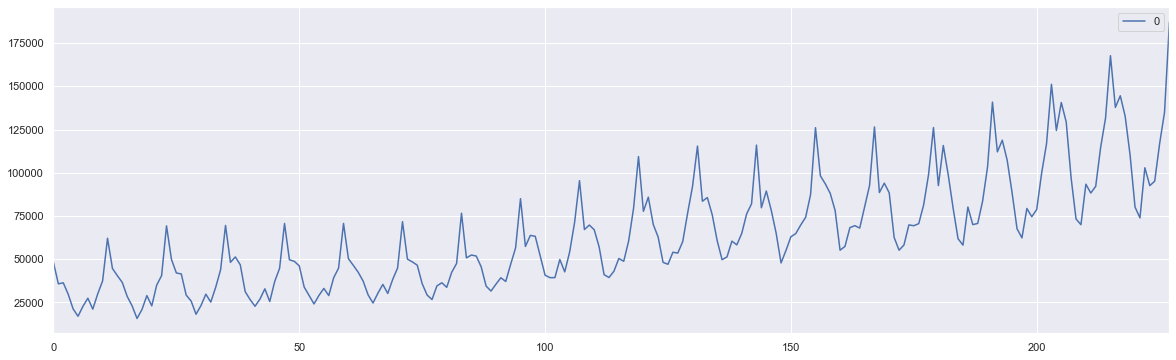

In [19]:
#1 Visualize
Signal.plot(figsize=(20,6))

### 2. Extract the time series components.


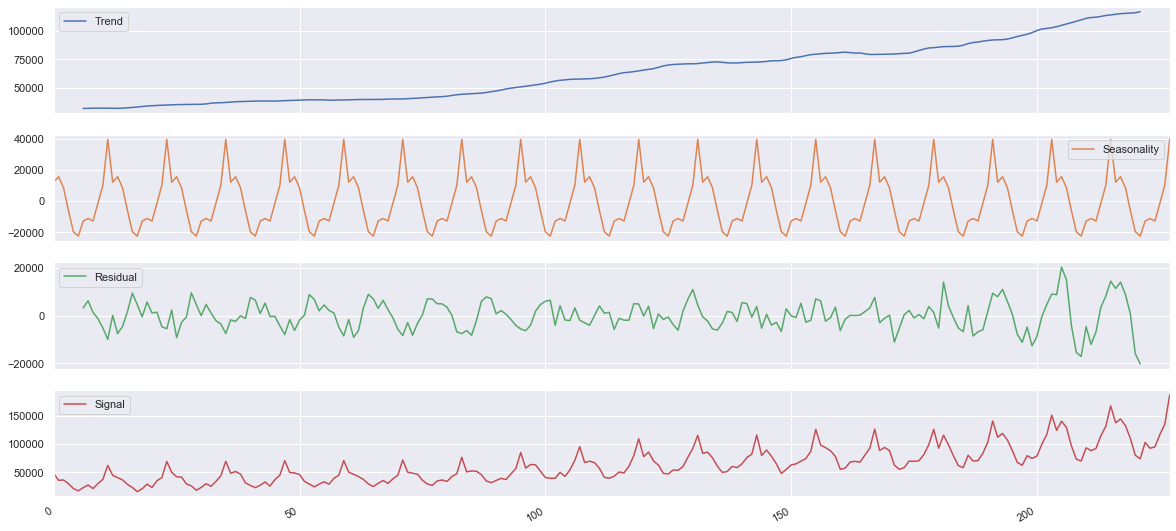

In [20]:
#2 Time series components
additive = seasonal_decompose(Signal[0],model="additive", period=12)
additive_df =pd.concat([additive.trend,additive.seasonal,additive.resid, additive.observed],axis=1)
additive_df.columns=["Trend","Seasonality","Residual","Signal"]
additive_df.plot(subplots=True,figsize=(20,10))
plt.show()

### 3. Partition your data into training, validation and testing sets. Justify the used technique for portioning. 

#### The data is splited using the iloc method to avoid shuffling the data and losing the time series logic

In [21]:
# 3 Partition your data 80:10:10
training_size = int(len(Signal)*0.8)
validation_size = int(len(Signal)*0.1)
testing_size = int(len(Signal)) - validation_size - training_size

In [22]:
Signal_train = Signal.iloc[:training_size]
Signal_val = Signal.iloc[training_size:training_size + validation_size]
Signal_test = Signal.iloc[training_size + validation_size:]

### 4. Scale you data using one technique. Justify the usage of data scaling.


#### Data scaling allow the machine learning models to learn quickly and to not get baised when trying to estimate the model weights

In [23]:
scaler = MinMaxScaler()
scaler.fit(Signal_train)
Scaled_training_data = scaler.transform(Signal_train)
Scaled_validation_data =scaler.transform(Signal_val)
Scaled_test_data = scaler.transform(Signal_test)

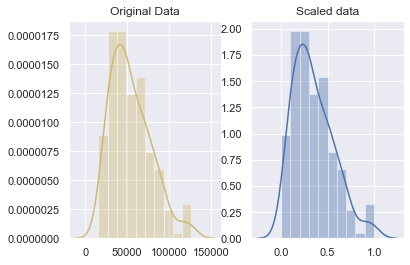

In [24]:
fig, ax=plt.subplots(1,2)
sns.distplot(Signal_train, ax=ax[0], color='y')
ax[0].set_title("Original Data")
sns.distplot(Scaled_training_data, ax=ax[1])
ax[1].set_title("Scaled data")
plt.show()

# I. Statistical modeling:


### 1. Is your data stationary? Justify your answer (use graphical interpretation and statistical tests).


In [25]:
#1 Data stationary?
adfuller_test_result =sts.adfuller(Signal[0])
print('p-value: ', adfuller_test_result[1])
if adfuller_test_result[1] > 0.05:
    print('The TS is Non-Stationary (p_val > 0.05)')
else:
    print('The TS is Stationary (p_val <= 0.05)')

p-value:  0.9989422642966919
The TS is Non-Stationary (p_val > 0.05)


### The mean and the std is changing through out the time series which makes the data non-stationary also the presence of seasonality makes this time series non-stationary 

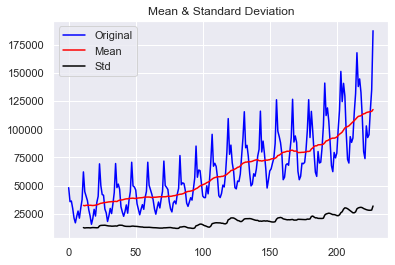

In [15]:
mean = Signal.rolling(window = 12).mean()
std = Signal.rolling(window = 12).std()
plt.plot(Signal, color = 'blue', label = 'Original')
plt.plot(mean, color = 'red', label = 'Mean')
plt.plot(std, color = 'black', label = 'Std')
plt.legend(loc = 'best')
plt.title('Mean & Standard Deviation')
plt.show()



### 2. If not, apply the required transformations and/or differentiations to make it stationary. 

the lambda of the Box-Cox transform:  0.11114933445227324


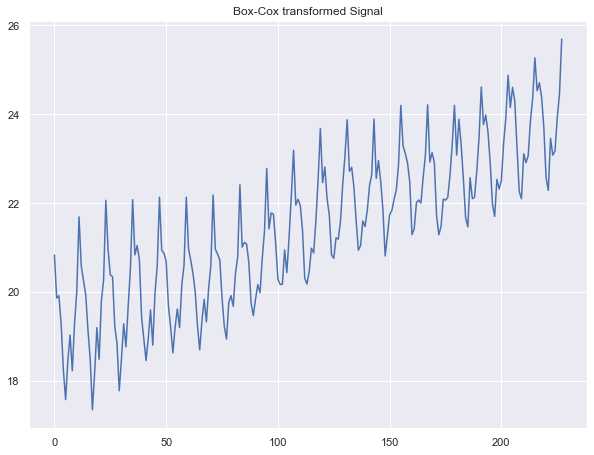

In [26]:
#2 Apply the required transformations and/or differentiations to make it stationary
# Stabilize the variance using the Box-Cox transform
Signal_BC, lmbda = stats.boxcox(Signal[0])
print('the lambda of the Box-Cox transform: ', lmbda)
# Plot TS_BC
plt.figure(figsize=[10, 7.5])
plt.title("Box-Cox transformed Signal")
plt.plot(Signal_BC)
plt.show()

In [27]:
adfuller_test_BC_result =sts.adfuller(Signal_BC)
print('p-value: ', adfuller_test_BC_result[1])
if adfuller_test_BC_result[1] > 0.05:
    print('The TS is Non-Stationary (p_val > 0.05)')
else:
    print('The TS is Stationary (p_val <= 0.05)')

p-value:  0.9816311391521655
The TS is Non-Stationary (p_val > 0.05)


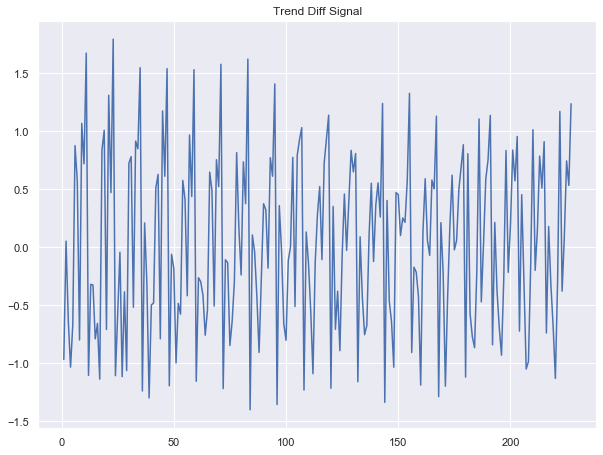

In [28]:
# Eliminate the trend
Signal_T_diff = pd.DataFrame(Signal_BC).diff()
Signal_T_diff = Signal_T_diff.drop(Signal_T_diff.index[0])
#Plot_Singal_T_Diff
plt.figure(figsize=[10, 7.5])
plt.title("Trend Diff Signal")
plt.plot(Signal_T_diff)
plt.show()

In [29]:
adfuller_test_TDIFF_result =sts.adfuller(Signal_T_diff[0])
print('p-value: ', adfuller_test_TDIFF_result[1])
if adfuller_test_TDIFF_result[1] > 0.05:
    print('The TS is Non-Stationary (p_val > 0.05)')
else:
    print('The TS is Stationary (p_val <= 0.05)')

p-value:  8.788390879171017e-05
The TS is Stationary (p_val <= 0.05)


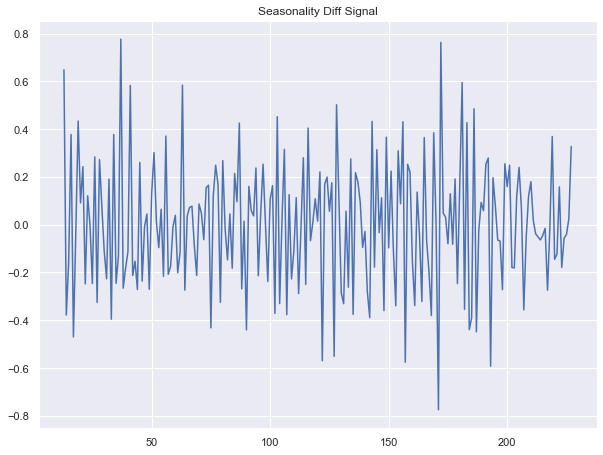

In [30]:
# Eliminate the seasonality
Signal_S_diff = pd.DataFrame(Signal_T_diff).diff(periods=12)
Signal_S_diff = Signal_S_diff.drop(Signal_S_diff.index[0:12])
#Plot_Singal_S_Diff
plt.figure(figsize=[10, 7.5])
plt.title("Seasonality Diff Signal")
plt.plot(Signal_S_diff)
plt.show()

In [31]:
adfuller_test_TSDIFF_result =sts.adfuller(Signal_S_diff[0])
print('p-value: ', adfuller_test_TSDIFF_result[1])
if adfuller_test_TSDIFF_result[1] > 0.05:
    print('The TS is Non-Stationary (p_val > 0.05)')
else:
    print('The TS is Stationary (p_val <= 0.05)')

p-value:  1.3690536815002095e-05
The TS is Stationary (p_val <= 0.05)


### 3. Plot the ACF and PACF of your time series

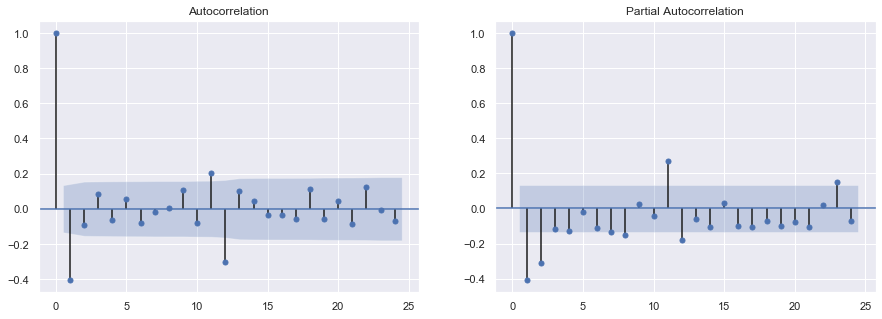

In [32]:
#3 plot acf & pacf
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(Signal_S_diff,ax[0],);
plot_pacf(Signal_S_diff,ax[1]);

### 4. Suggest a set of candidate models.


#### The ACF & PACF plots shows that the ACF cuts off after q=1, and PACF cuts off after p=2
#### I will be trying all these models: ARMA(1,1) , ARMA(1,2) , ARMA(2,1) and eventually SARMA(1,1,2)(1,1,2,12)

### 5. Run each model on your training data and save the training performances.

In [46]:
Stationary_Signal = Signal_S_diff.reset_index(drop=True)
Stationary_Signal_train = Stationary_Signal.iloc[:173]
Stationary_Signal_val = Stationary_Signal.iloc[173:173+21]
Stationary_Signal_test = Stationary_Signal.iloc[173+21:]

## ARMA(1,1)

In [47]:
model_arma_11 = ARIMA(Stationary_Signal_train, order=(1,0,1))
model_fit_arma_11=model_arma_11.fit()
print(model_fit_arma_11.summary())

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                  173
Model:                     ARMA(1, 1)   Log Likelihood                   4.979
Method:                       css-mle   S.D. of innovations              0.235
Date:                Sun, 31 Jan 2021   AIC                             -1.958
Time:                        04:37:36   BIC                             10.655
Sample:                             0   HQIC                             3.159
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.005      0.321      0.748      -0.008       0.012
ar.L1.0        0.1058      0.144      0.733      0.463      -0.177       0.389
ma.L1.0       -0.7495      0.112     -6.691      0.0

## ARMA(1,2)

In [48]:
model_arma_12 = ARIMA(Stationary_Signal_train, order=(1,0,2))
model_fit_arma_12=model_arma_12.fit()
print(model_fit_arma_12.summary())

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                  173
Model:                     ARMA(1, 2)   Log Likelihood                   8.730
Method:                       css-mle   S.D. of innovations              0.228
Date:                Sun, 31 Jan 2021   AIC                             -7.460
Time:                        04:37:54   BIC                              8.306
Sample:                             0   HQIC                            -1.064
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.006      0.313      0.754      -0.009       0.013
ar.L1.0       -0.8814      0.039    -22.319      0.000      -0.959      -0.804
ma.L1.0        0.2968      0.069      4.309      0.0

## ARMA(2,1)

In [49]:
model_arma_21 = ARIMA(Stationary_Signal_train, order=(2,0,1))
model_fit_arma_21=model_arma_21.fit()
print(model_fit_arma_21.summary())

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                  173
Model:                     ARMA(2, 1)   Log Likelihood                   5.851
Method:                       css-mle   S.D. of innovations              0.233
Date:                Sun, 31 Jan 2021   AIC                             -1.702
Time:                        04:39:38   BIC                             14.065
Sample:                             0   HQIC                             4.695
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.174      0.862      -0.004       0.004
ar.L1.0        0.2955      0.100      2.964      0.003       0.100       0.491
ar.L2.0        0.1754      0.096      1.824      0.0

## SARIMA(1,1,2)(1,1,2,12)

In [78]:
model=sm.tsa.statespace.SARIMAX(Signal_train,orders=(1, 1, 2),seasonal_order=(1,1,2,12))
model_fit=model.fit()
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       0   No. Observations:                  182
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood               -1675.885
Date:                                 Sun, 31 Jan 2021   AIC                           3361.770
Time:                                         05:07:47   BIC                           3377.449
Sample:                                              0   HQIC                          3368.133
                                                 - 182                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2625      0.034      7.610      0.000       0.195       0

### 6. Select the best model based on validation performance.

In [183]:

ARMA_11_val_pred = model_fit_arma_11.predict(start=len(Stationary_Signal_train),end=len(Stationary_Signal_val)+len(Stationary_Signal_train)-1,dynamic=False)

RMSE_val_ARMA_11 = sqrt(mean_squared_error(Stationary_Signal_val, ARMA_11_val_pred))
MAE_11 = mean_absolute_error(Stationary_Signal_val, ARMA_11_val_pred)

print("ARMA(1,1): VAL RMSE ERROR  ",round(RMSE_val_ARMA_11,2)," VAL MAE ERROR ", round(MAE_11,2))


ARMA_12_val_pred = model_fit_arma_12.predict(start=len(Stationary_Signal_train),end=len(Stationary_Signal_val)+len(Stationary_Signal_train)-1,dynamic=False)

RMSE_val_ARMA_12 = sqrt(mean_squared_error(Stationary_Signal_val, ARMA_12_val_pred))
MAE_12 = mean_absolute_error(Stationary_Signal_val, ARMA_12_val_pred)

print("ARMA(1,2): VAL RMSE ERROR  ",round(RMSE_val_ARMA_12,2)," VAL MAE ERROR ", round(MAE_12,2))

ARMA_21_val_pred = model_fit_arma_21.predict(start=len(Stationary_Signal_train),end=len(Stationary_Signal_val)+len(Stationary_Signal_train)-1,dynamic=False)

RMSE_val_ARMA_21 = sqrt(mean_squared_error(Stationary_Signal_val, ARMA_21_val_pred))
MAE_21 = mean_absolute_error(Stationary_Signal_val, ARMA_21_val_pred)

print("ARMA(2,1): VAL RMSE ERROR  ",round(RMSE_val_ARMA_21,2)," VAL MAE ERROR ", round(MAE_21,2))

ARMA(1,1): VAL RMSE ERROR   0.24  VAL MAE ERROR  0.2
ARMA(1,2): VAL RMSE ERROR   0.25  VAL MAE ERROR  0.2
ARMA(2,1): VAL RMSE ERROR   0.24  VAL MAE ERROR  0.2


### Because the validation performance of the 3 models is quite similar, I'll be choosing the model with the lowest AIC and the most significant coefficients ARMA(1,2)
### Eventually the final model that will be used to model the original series is going to be a SARIMA Model because of the presence of seasonality & the non-stationarity of the TIME SERIES experimentally this one gives better results & follow the under laying logic of the DATA

### 7. Evaluate the errors of your model using residual analysis.

### The residuals follows a gauss distribution

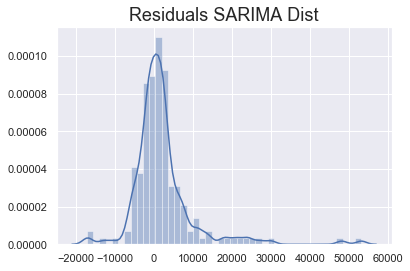

In [188]:
sns.distplot(model_fit.resid)
plt.title("Residuals SARIMA Dist",size = 18)
plt.show()

## 8. Are your residuals white noise? (Use graphical interpretation and statistical tests).

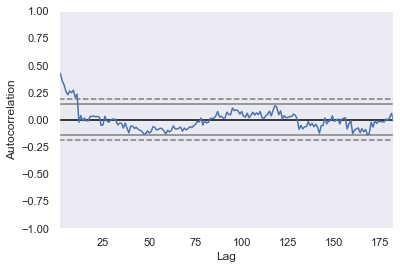

In [185]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(model_fit.resid)
plt.show()

## <center> Ljung_Box White Noise Test </center>
### Null Hypothesis : There is no autocorrelation between the signal and its lagged version
### Alternate Hypothesis : There is significant autocorrelation between the signal and its lagged version


In [190]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(model_fit.resid,period=12,return_df=True)

,lb_stat,lb_pvalue
1,34.370945,4.554721e-09
2,67.754891,1.937369e-15
3,91.194092,1.213569e-19
4,110.239881,6.468911e-23
5,122.917721,7.560534e-25
6,132.834643,3.250366e-26
7,146.010872,2.791734e-28
8,157.790662,4.632462e-30
9,171.941368,2.431203e-32
10,179.818445,2.555414e-33


### Since the p-value < 0.5 we reject the Null Hypothesis thus There is significant autocorrelation between the signal and its lagged version (the residuals are not a white noise series)

## 9. If not, model your residuals using heteroskedastic models.

In [191]:
import arch
garch_model = arch.arch_model(model_fit.resid,p=1,q=2)
garch_fitted = garch_model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6002.701275285661
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1830.0598592585484
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1829.4446026796486
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1829.4037075721599
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1829.399337932935
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1829.3990613167616
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1829.3989195653467
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1829.398557924079
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1829.3976267847797
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1829.3950340940705
Iteration:     11,   Func. Count:     69,   Neg. LLF: 1829.3887782500465
Iteration:     12,   Func. Count:     75,   Neg. LLF: 1829.370550131861
Iteration:     13,   Func. Count:     81,   Neg. LLF: 1829.3278198824469
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

## 10. Generate forecasts based on the selected model.


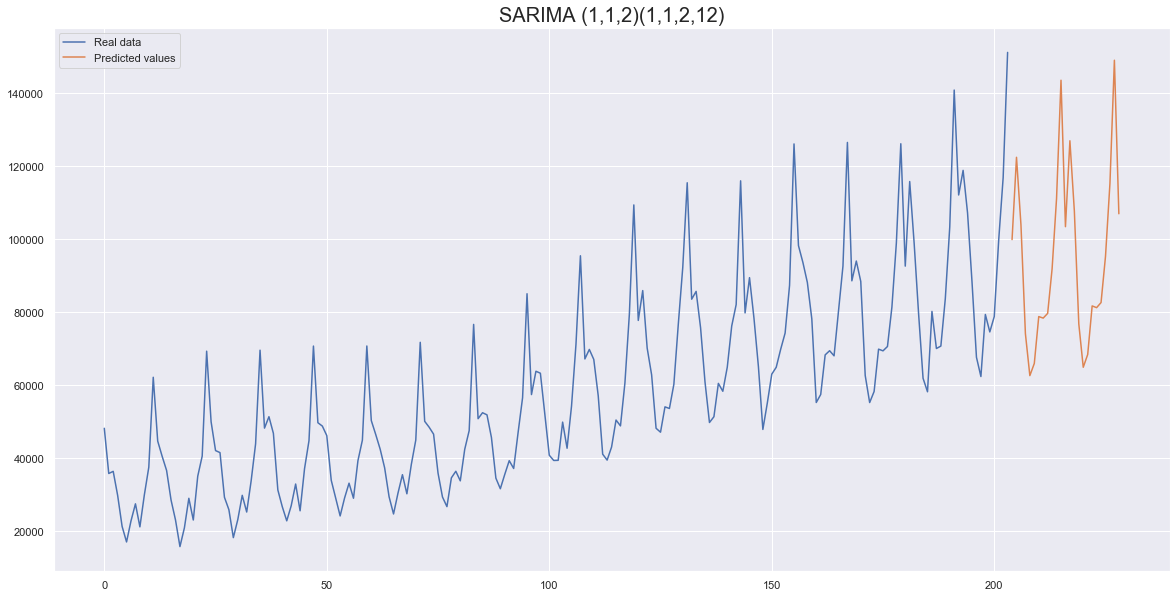

In [195]:
plt.figure(figsize=(20,10))
df_pred = model_fit.predict(start=training_size+validation_size,end=validation_size+training_size+testing_size,dynamic=False)
plt.plot(Signal[:training_size+validation_size],label="Real data")
plt.plot(df_pred,label="Predicted values")
plt.title("SARIMA (1,1,2)(1,1,2,12)",size=20)
plt.legend()
plt.show()

## 11. Plot the real and estimated training, validation and testing data in one graph

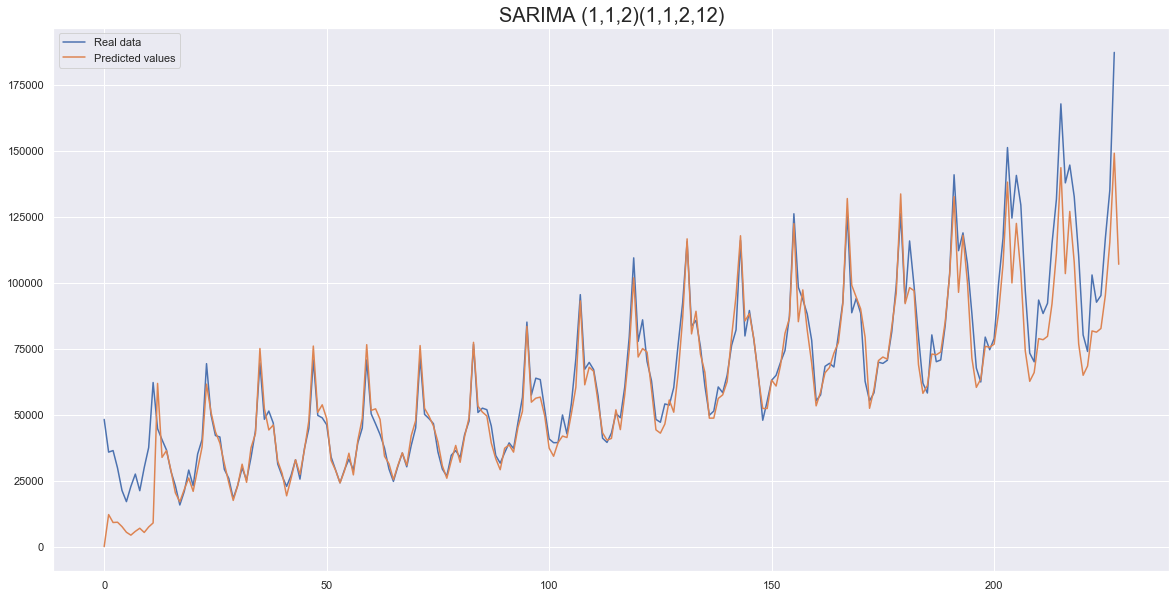

In [208]:
plt.figure(figsize=(20,10))
df_pred = model_fit.predict(start=0,end=validation_size+training_size+testing_size,dynamic=False)
plt.plot(Signal,label="Real data")
plt.plot(df_pred,label="Predicted values")
plt.title("SARIMA (1,1,2)(1,1,2,12)",size=20)
plt.legend()
plt.show()

## 12. Provide the training and testing error for your model.


In [210]:
predicted_ = model_fit.predict(start = 0, end = Signal.shape[0])
predicted_training_ = predicted.iloc[:training_size]
predicted_test_ = predicted.iloc[-testing_size:]
MAE_train_ = mean_absolute_error(Signal_train, predicted_training_)
MAE_test_ = mean_absolute_error(Signal_test, predicted_test_)

print(" TRAIN MAE ERROR  ",round(MAE_train_,2)," TEST MAE ERROR ", round(MAE_test_,2))

 TRAIN MAE ERROR   54346.21  TEST MAE ERROR  113806.67
